In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

In [4]:
instructpart_test_dir = "/data/VLMGroundingProject/Datasets/InstructPart/test"

masks_dir = os.path.join(instructpart_test_dir, "masks")
images_dir = os.path.join(instructpart_test_dir, "images")
image_names = os.listdir(images_dir)

In [5]:
def load_mask_and_parse_name(image_name, masks_dir):
    """
    Load mask and extract object and part names from filename.
    
    Args:
        image_name: Name of the image file (with or without extension)
        masks_dir: Directory containing the mask files
    
    Returns:
        mask: Loaded mask as numpy array
        object_name: Name of the object
        part_name: Name of the part
    """
    #get basename
    basename = os.path.splitext(image_name)[0]
    
    # mask 
    mask_path = os.path.join(masks_dir, f"{basename}.png")
    mask = np.array(Image.open(mask_path))
    
    # parse the filename: image_id-object_name-part_name
    filename_parts = basename.split('-')
    part_name = filename_parts[-1]
    object_name = filename_parts[-2]

    return mask, object_name, part_name

In [6]:
import sys
sys.path.append('/home/ksmehrab/AttentionGrounding/ModelPlaygrounds/SegZero/GitRepoLatest/Seg-Zero')

import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
from sam2.sam2_image_predictor import SAM2ImagePredictor
import re

/home/ksmehrab/miniconda/envs/segzero/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Configuration
reasoning_model_path = "/data/VLMGroundingProject/ModelData/SegZero/visionreasoner_workdir/run_visionreasoner_7b_2x160G_dataset_instructpart_vrpretrained_partreward1/global_step_112/actor/huggingface"
save_dir = "/data/VLMGroundingProject/BaselineResults/InstructPart/VRPart/debug"
os.makedirs(save_dir, exist_ok=True)
max_response_length = 2000
batch_size = 16
debug = True  # Set to True to save visualizations

In [8]:
QUESTION_TEMPLATE = \
    "Please find \"{Question}\" with bboxs and points. " \
    "Boxes must be tight and compact (no extra background)." \
    "The representative point must lie inside the object or part. If nothing matches, output an empty list []. \n\n" \
    "STEP 1 — THINK:\n" \
    'First, decide whether you need to find a "whole object" or a "part" within an object. ' \
    "Reason about where the object or the part is. If a part is required, reason where the part lies within the object and " \
    "make sure any proposed box is for the part (not the whole object) when the query is a part. " \
    "Output your thinking in <think> </think> tags.\n\n" \
    'Output your decision about whether you are finding an "object" or a "part" in <decide> </decide> tags\n\n' \
    "STEP 2 — FIRST ANSWER:\n" \
    "Based on your thinking and decision, generate an initial prediction in <first_answer> </first_answer> tags, " \
    "containing a JSON list of entries with bbox_2d and point_2d.\n\n" \
    "STEP 3 — CRITICISM:\n" \
    "Check if your first answer tightly encloses the required object or object part. " \
    "If adjustments are needed, describe the issue and suggested adjustments. Example of necessary adjustments could be to make the bboxes smaller or bigger, or move the bboxes in any direction. " \
    "Output this in <criticism> </criticism> tags.\n\n" \
    "STEP 4 — FINAL ANSWER:\n" \
    "Adjust the first_answer based on the criticism, and output your adjusted final answer in <final_answer> </final_answer> tags containing a JSON list of entries with bbox_2d and point_2d.\n\n" \
    "Output format example " \
    "<think> thinking process here </think> " \
    '<decide> I am finding an "object"|"object part" </decide> ' \
    '<first_answer>[{{"bbox_2d":[x1,y1,x2,y2],"point_2d":[cx,cy]}}]</first_answer> ' \
    "<criticism> critic of first answer and necessary adjustments here </criticism> " \
    '<final_answer>[{{"bbox_2d":[x1,y1,x2,y2],"point_2d":[cx,cy]}}]</final_answer>'

In [9]:
def extract_information_vrpart(output_text, x_factor, y_factor):
    """Extract bboxes, points and parsed output from model response"""
    # Extract think tag
    think_pattern = r'<think>([^<]+)</think>'
    think_match = re.search(think_pattern, output_text)
    think_text = think_match.group(1).strip() if think_match else ""
    
    # Extract decide tag
    decide_pattern = r'<decide>([^<]+)</decide>'
    decide_match = re.search(decide_pattern, output_text)
    decide_text = decide_match.group(1).strip() if decide_match else ""
    
    # Extract first_answer tag
    first_answer_pattern = r'<first_answer>\s*(.*?)\s*</first_answer>'
    first_answer_match = re.search(first_answer_pattern, output_text, re.DOTALL)
    first_answer_text = first_answer_match.group(1).strip() if first_answer_match else ""
    
    # Extract criticism tag
    criticism_pattern = r'<criticism>([^<]+)</criticism>'
    criticism_match = re.search(criticism_pattern, output_text)
    criticism_text = criticism_match.group(1).strip() if criticism_match else ""
    
    # Extract final_answer and parse bbox/points
    final_answer_pattern = r'<final_answer>\s*(.*?)\s*</final_answer>'
    final_answer_match = re.search(final_answer_pattern, output_text, re.DOTALL) 
    final_answer_text = final_answer_match.group(1).strip() if final_answer_match else ""

    output_text_parsed = {
        "think": think_text,
        "decide": decide_text,
        "first_answer": first_answer_text,
        "criticism": criticism_text,
        "final_answer": final_answer_text
    }
    
    pred_bboxes = []
    pred_points = []
    
    if final_answer_match:
        data = json.loads(final_answer_match.group(1))
        pred_bboxes = [[
            int(item['bbox_2d'][0] * x_factor + 0.5),
            int(item['bbox_2d'][1] * y_factor + 0.5),
            int(item['bbox_2d'][2] * x_factor + 0.5),
            int(item['bbox_2d'][3] * y_factor + 0.5)
        ] for item in data]
        pred_points = [[
            int(item['point_2d'][0] * x_factor + 0.5),
            int(item['point_2d'][1] * y_factor + 0.5)
        ] for item in data]

    return pred_bboxes, pred_points, output_text_parsed

def compute_iou(mask1, mask2):
    """Compute intersection and union between two masks"""
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0, 0
    return intersection, union


In [10]:
# visualization code from chatgpt
def visualize_bbox_comparison(image, first_bboxes, final_bboxes, query_text):
    """
    Visualize side-by-side comparison of first_answer and final_answer bounding boxes.
    
    Args:
        image: PIL Image object
        first_bboxes: List of bboxes from first_answer [[x1,y1,x2,y2], ...]
        final_bboxes: List of bboxes from final_answer [[x1,y1,x2,y2], ...]
        query_text: Query text for the image
        save_path: Path to save the visualization
    """
    plt.figure()
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    print("debugfigure")
    # First answer boxes
    axes[0].imshow(image)
    axes[0].set_title(f'First Answer Boxes\n{query_text}', fontsize=14, fontweight='bold')
    for idx, box in enumerate(first_bboxes):
        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                            linewidth=3, edgecolor='blue', facecolor='none')
        axes[0].add_patch(rect)
        axes[0].text(x1, y1-5, f"First_{idx}", color='blue', fontsize=12,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    axes[0].axis('off')
    axes[0].text(0.5, -0.05, f'{len(first_bboxes)} boxes', 
                transform=axes[0].transAxes, ha='center', fontsize=12)
    
    # Final answer boxes
    axes[1].imshow(image)
    axes[1].set_title(f'Final Answer Boxes\n{query_text}', fontsize=14, fontweight='bold')
    for idx, box in enumerate(final_bboxes):
        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                            linewidth=3, edgecolor='red', facecolor='none')
        axes[1].add_patch(rect)
        axes[1].text(x1, y1-5, f"Final_{idx}", color='red', fontsize=12,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    axes[1].axis('off')
    axes[1].text(0.5, -0.05, f'{len(final_bboxes)} boxes', 
                transform=axes[1].transAxes, ha='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    # plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    # print(f"Saved box comparison to {save_path}")

In [11]:
# load models
print("Loading reasoning model...")
reasoning_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    reasoning_model_path,
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto",
)
reasoning_model.eval()

print("Loading segmentation model...")
segmentation_model = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-large")

processor = AutoProcessor.from_pretrained(reasoning_model_path, padding_side="left")

Loading reasoning model...


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]


Loading segmentation model...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Already done: 0. Processing remaining: 600...


  0%|          | 0/1 [00:00<?, ?it/s]

Output for wine_glass_002366-wine_glass-body.jpg:
<think> The task involves identifying the "wine_glass's body" which typically refers to the main part of the glass excluding the stem and base. In the image, there are two glasses filled with a bubbly liquid, likely champagne, and the focus is on the body of these glasses. The stem and base are not part of the "body" in this context.</think>
<decide> I am finding an "object part"</decide>
<first_answer>[{"bbox_2d":[479,132,589,550],"point_2d":[520,365]}, {"bbox_2d":[599,143,710,550],"point_2d":[655,365]}]</first_answer>
<criticism> The initial answer provided the bounding boxes for the entire glasses, including the stem and base. To strictly adhere to the task, we need to adjust the bounding boxes to only include the body of the glasses, which excludes the stem and base.</criticism>
<final_answer>[{"bbox_2d":[479,132,589,550],"point_2d":[520,365]}, {"bbox_2d":[599,143,710,550],"point_2d":[655,365]}]</final_answer><|im_end|>
------------

<Figure size 640x480 with 0 Axes>

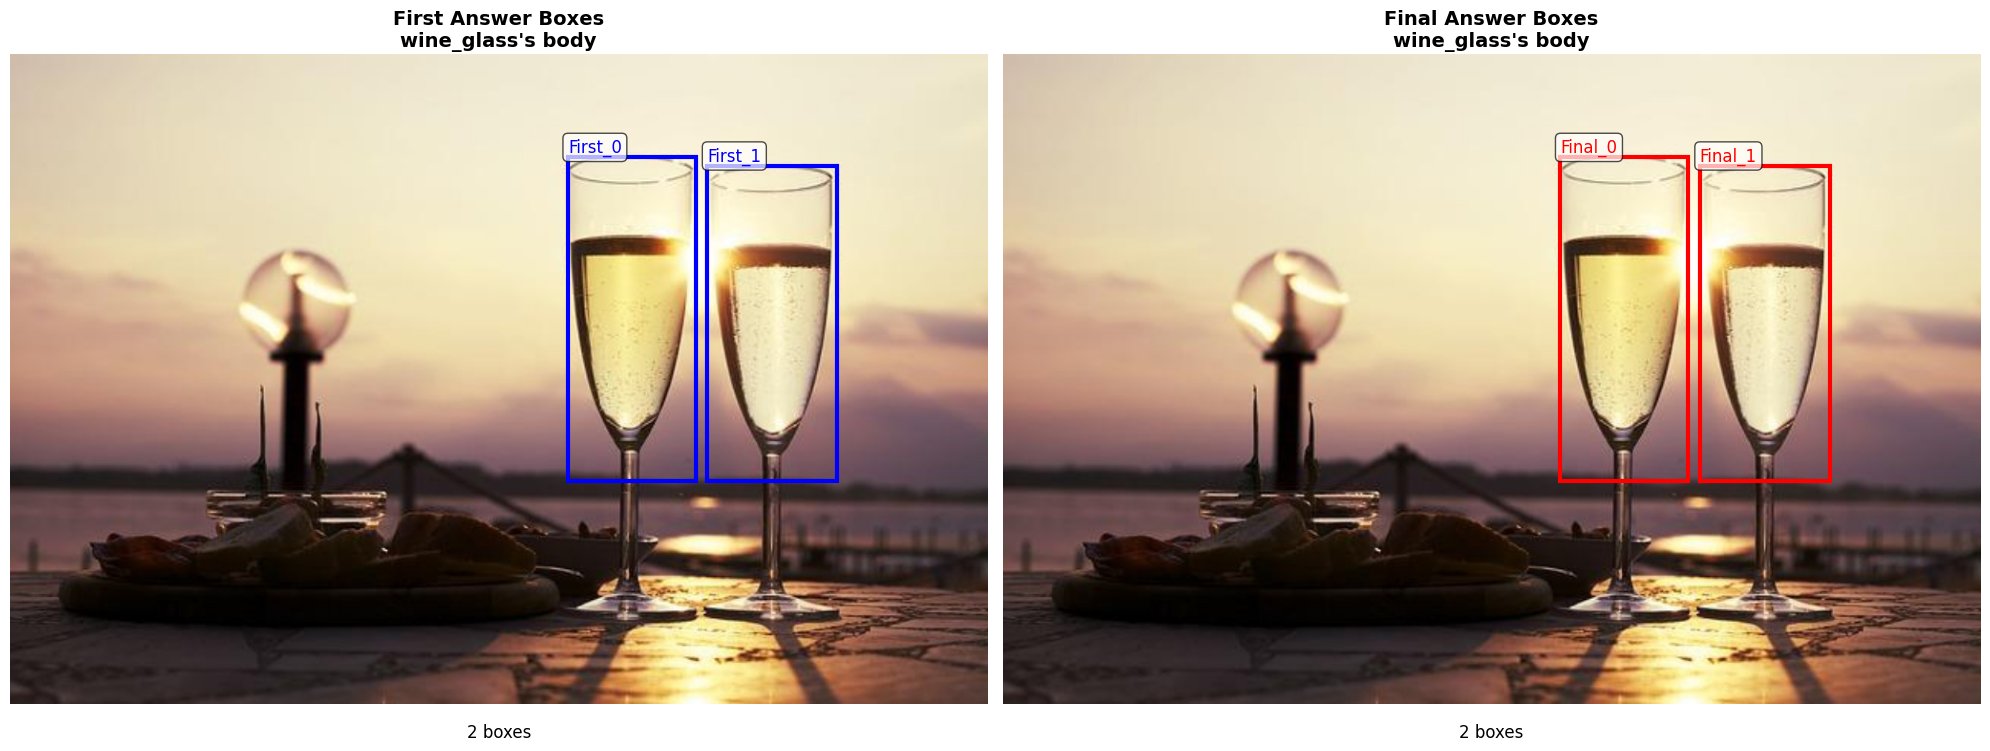

Output for suitcase_3-suitcase-wheel.jpg:
<think> The task involves identifying the "suitcase's wheel" which is a specific part of the suitcase. The suitcase is clearly visible in the image, and the wheels are distinct parts that can be pinpointed. The wheels are located at the bottom of the suitcase, and they are black, matching the suitcase's color. The requirement is to find the wheels, which are parts of the suitcase, not the whole suitcase.</think>
<decide>I am finding an "object part"</decide>
<first_answer>[{"bbox_2d":[230,724,263,765],"point_2d":[249,740]}, {"bbox_2d":[418,727,446,771],"point_2d":[432,743]}]</first_answer>
<criticism> The initial answer provided the correct bounding boxes for the wheels, but they could be slightly adjusted to be more compact and precise, ensuring they tightly enclose the wheels without including any unnecessary background elements.</criticism>
<final_answer>[{"bbox_2d":[230,724,263,765],"point_2d":[249,740]}, {"bbox_2d":[418,727,446,771],"point

<Figure size 640x480 with 0 Axes>

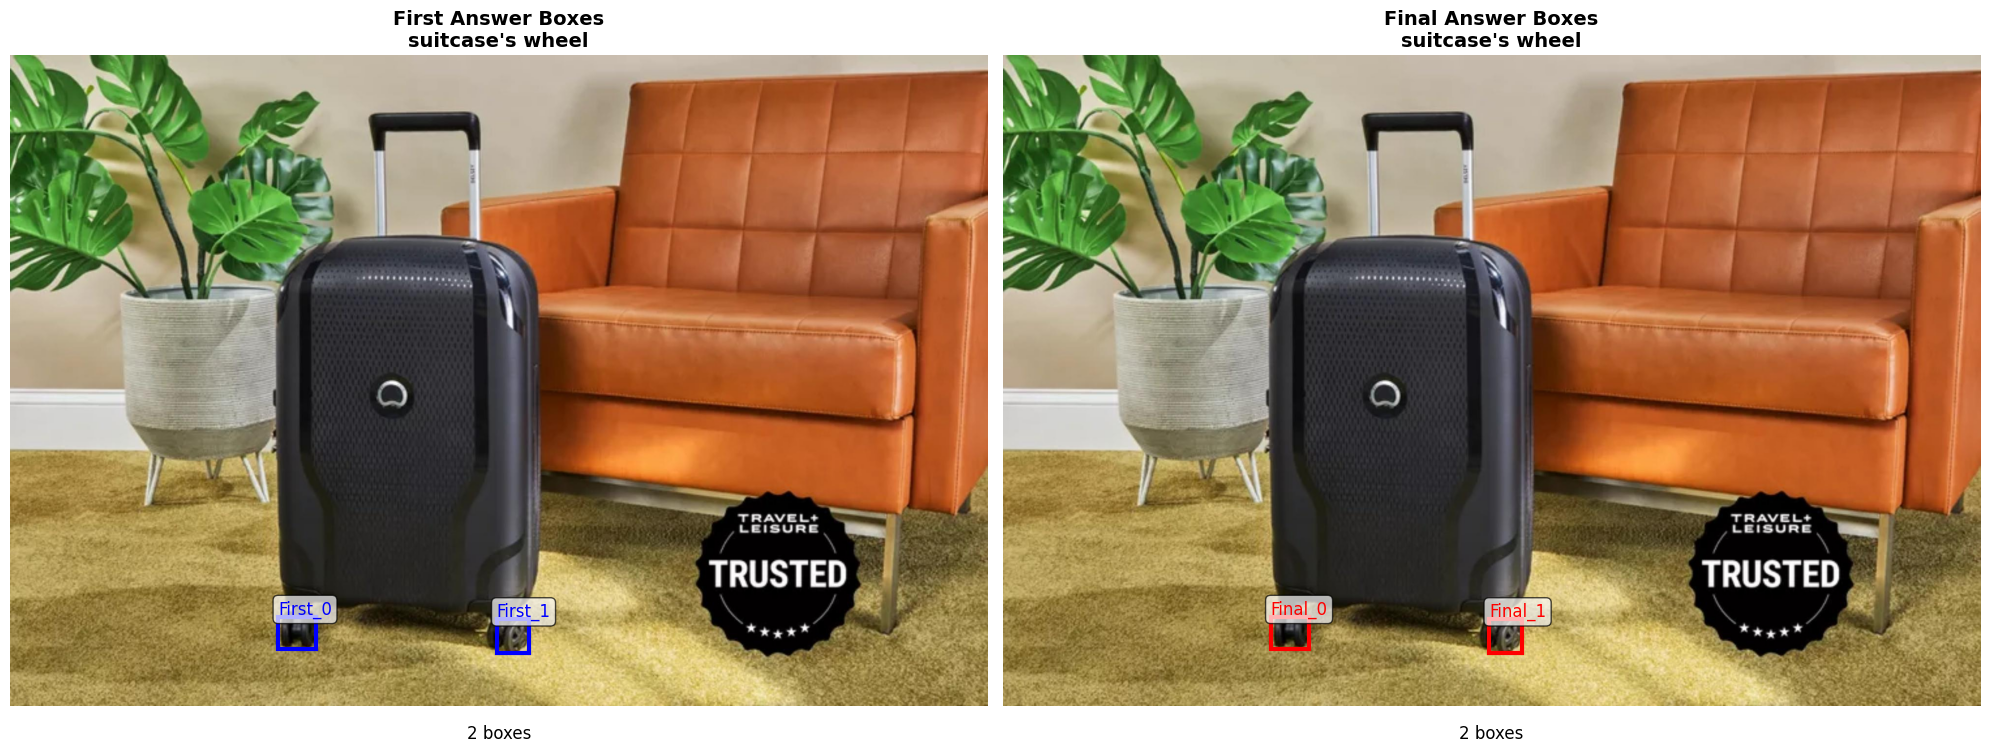

Output for 12214322195_ea934fe3ff_o-bottle-body.jpg:
<think> The task is to identify and box the "bottle's body" which is the main part of the bottle excluding the cap and label. The bottle's body is the clear glass part that contains the liquid.</think>
<decide>I am finding an "object part"</decide>
<first_answer>[{"bbox_2d":[60,180,486,580],"point_2d":[252,350]}]</first_answer>
<criticism> The initial answer box is too large, including the cap and part of the label. To better fit the "bottle's body," the box should be adjusted to exclude the cap and the label area.</criticism>
<final_answer>[{"bbox_2d":[60,180,486,580],"point_2d":[252,350]}]</final_answer><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im

<Figure size 640x480 with 0 Axes>

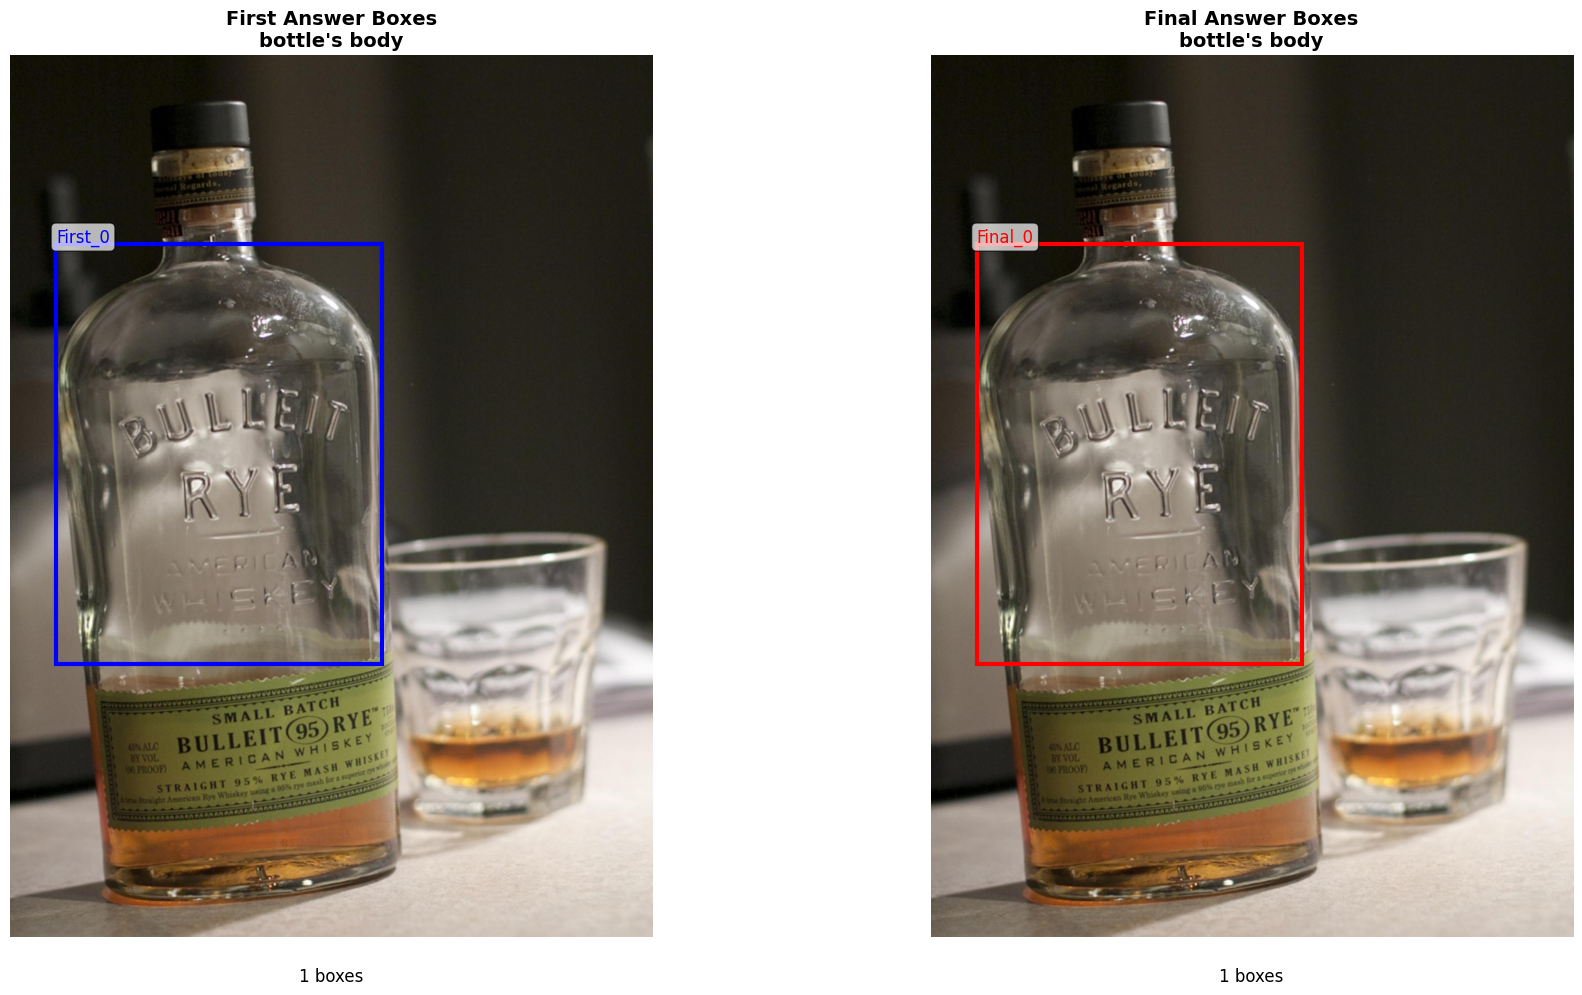

Output for fork_002952-fork-tines.jpg:
<think> The task involves identifying the "fork's tines" which are the prongs at the top of the fork. These are distinct from the handle and are the part of the fork used for eating. The tines are clearly visible and separate from the handle in the image.</think>
<decide>I am finding an "object part"</decide>
<first_answer>[{"bbox_2d":[425,74,555,238],"point_2d":[464,159]}]</first_answer>
<criticism> The initial answer provided a bounding box that includes the tines but is slightly larger than necessary. Adjusting the bounding box to be tighter will ensure it is compact and only includes the tines.</criticism>
<final_answer>[{"bbox_2d":[425,74,555,238],"point_2d":[464,159]}]</final_answer><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|i

<Figure size 640x480 with 0 Axes>

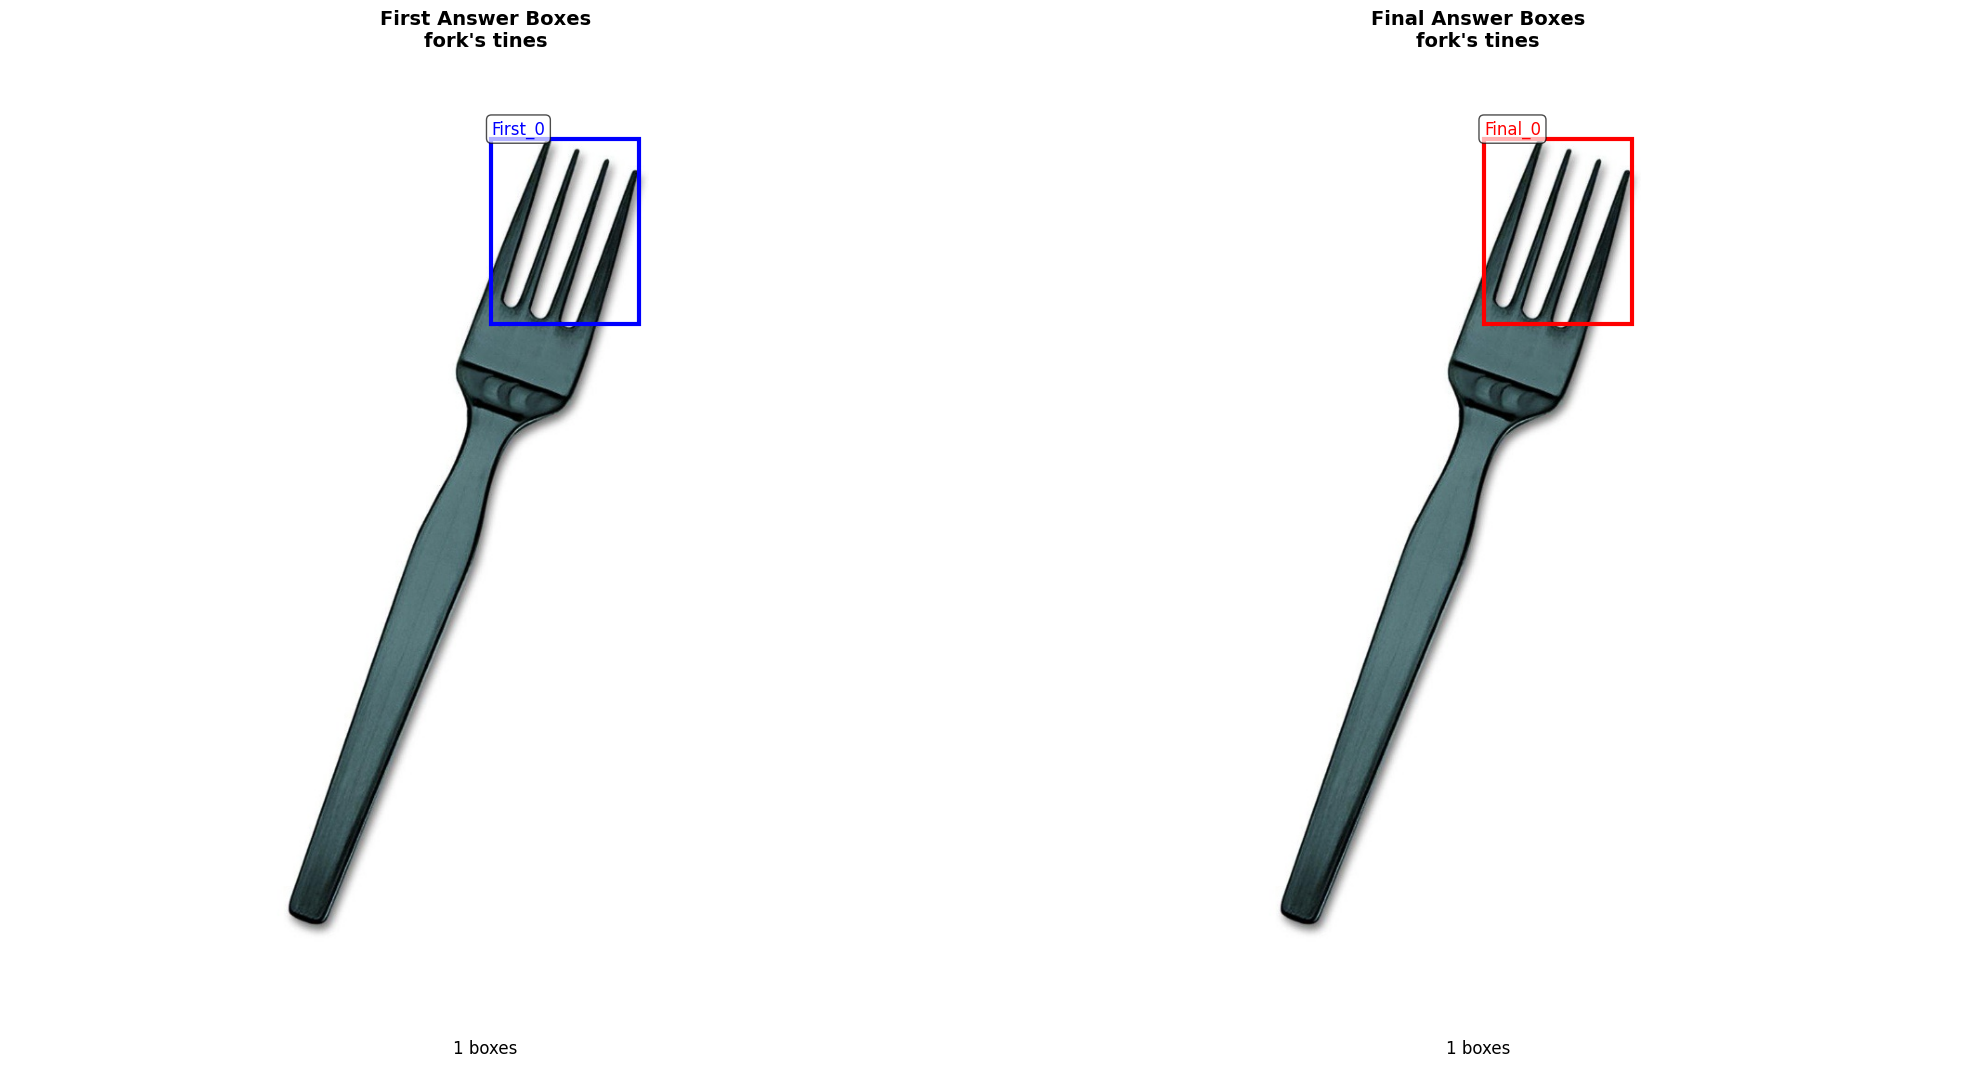

Output for cup_001668-cup-body.jpg:
<think> The query asks for the "cup's body," which is a part of the cup. The cup's body is the main part of the cup excluding the handle and the rim. The handle and rim are not part of the "cup's body" as per the query. The cup's body is the white, smooth part of the cup that holds the coffee.</think>
<decide> I am finding an "object part"</decide>
<first_answer>[{"bbox_2d":[65,25,375,370],"point_2d":[189,230]}]</first_answer>
<criticism> The initial answer provided a bounding box that includes the handle and rim, which are not part of the "cup's body." To better match the query, the bounding box should be adjusted to exclude the handle and rim.</criticism>
<final_answer>[{"bbox_2d":[65,25,375,370],"point_2d":[189,230]}]</final_answer><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|><|im_end|

<Figure size 640x480 with 0 Axes>

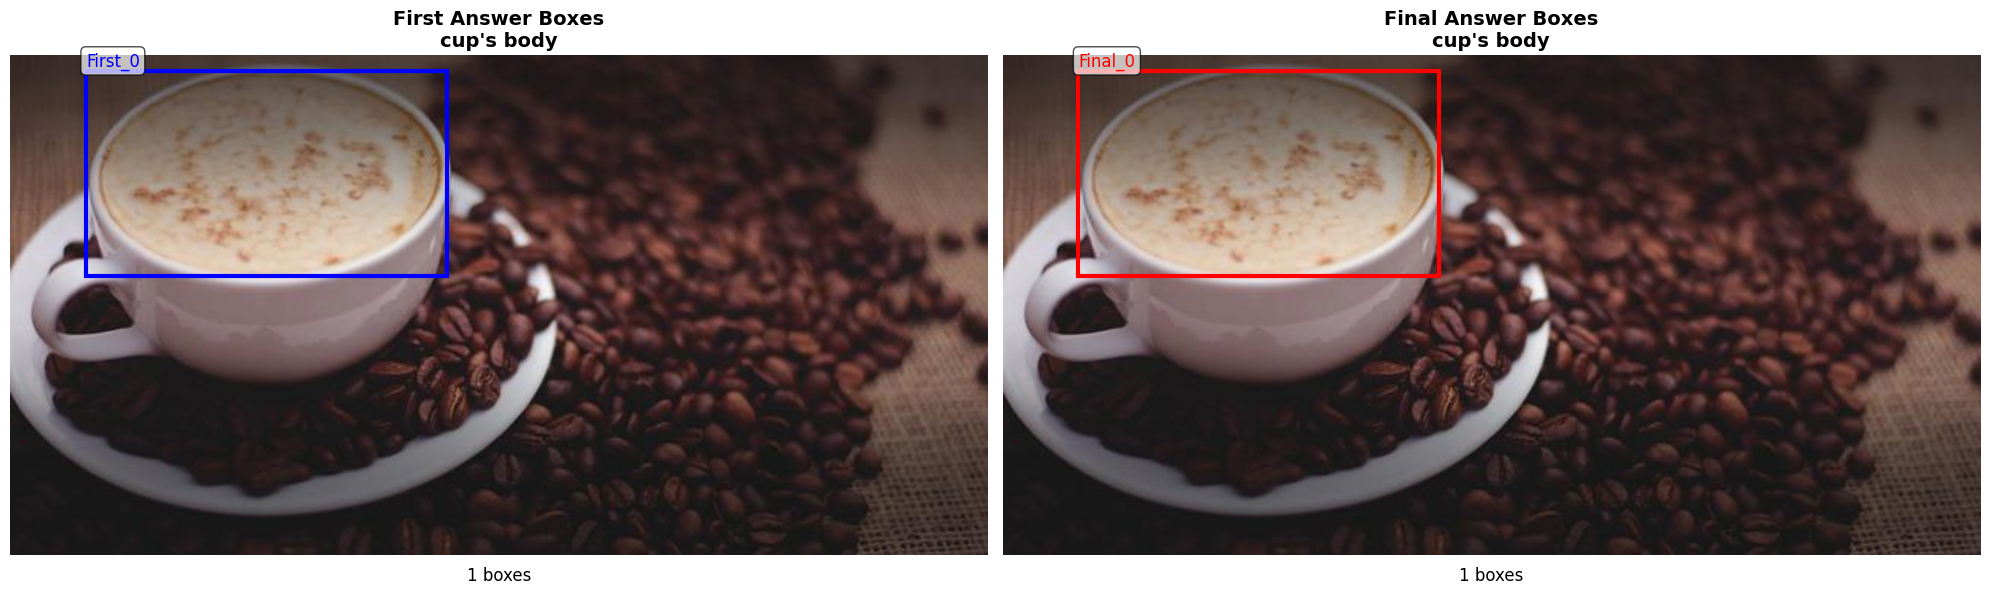

100%|██████████| 1/1 [00:20<00:00, 20.54s/it]

results saved to /data/VLMGroundingProject/BaselineResults/InstructPart/VRPart/debug


In [12]:
# Get already processed images
already_done = set(os.listdir(save_dir))
req_filenames = [img_name for img_name in image_names if img_name not in already_done]

print(f'Already done: {len(already_done)}. Processing remaining: {len(req_filenames)}...')

all_results = []
resize_size = 840

if debug:
    req_filenames = req_filenames[:5]  # do first 5 images in debug mode

for batch_start in tqdm(range(0, len(req_filenames), batch_size)):
    batch_filenames = req_filenames[batch_start: batch_start + batch_size]

    # prepare batch data
    batch_messages = []
    batch_metadata = []
    
    for image_name in batch_filenames:
        # Load image
        img_filepath = os.path.join(images_dir, image_name)
        image = Image.open(img_filepath).convert("RGB")
        original_width, original_height = image.size
        x_factor, y_factor = original_width/resize_size, original_height/resize_size
        
        # Load ground truth mask and parse names
        gt_mask, object_name, part_name = load_mask_and_parse_name(image_name, masks_dir)
        
        # Create query text (part within object)
        query_text = f"{object_name}'s {part_name}"
        
        # Prepare message for model
        message = [{
            "role": "user",
            "content": [
                {
                    "type": "image", 
                    "image": image.resize((resize_size, resize_size), Image.BILINEAR)
                },
                {   
                    "type": "text",
                    "text": QUESTION_TEMPLATE.format(Question=query_text.lower().strip("."))
                }
            ]
        }]

        batch_messages.append(message)
        batch_metadata.append({
            "image_name": image_name,
            "image": image,
            "original_width": original_width,
            "original_height": original_height,
            "x_factor": x_factor,
            "y_factor": y_factor,
            "gt_mask": gt_mask,
            "object_name": object_name,
            "part_name": part_name,
            "query_text": query_text
        })

    # Prepare inputs
    texts = [processor.apply_chat_template(message, tokenize=False, add_generation_prompt=True) for message in batch_messages]
    
    image_inputs, video_inputs = process_vision_info(batch_messages)

    inputs = processor(
        text=texts,
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    ).to("cuda")
    
    # Generate reasoning output
    with torch.inference_mode():
        generated_ids = reasoning_model.generate(**inputs, use_cache=True, max_new_tokens=max_response_length, do_sample=False)
        generated_ids_trimmed = [out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
        output_texts = processor.batch_decode(generated_ids_trimmed, skip_special_tokens=False, clean_up_tokenization_spaces=False)
    
    # process each item in the batch
    for output_text, metadata in zip(output_texts, batch_metadata):
        if debug:
            print(f"Output for {metadata['image_name']}:\n{output_text}\n{'-'*50}\n")
        
        try:
            bboxes, points, parsed_output = extract_information_vrpart(
                output_text, metadata['x_factor'], metadata['y_factor']
            )

            # visualize the first and final boxes in debug
            if debug and parsed_output['first_answer']:
                try:
                    # print("debugdebug")
                    first_answer_data = json.loads(parsed_output['first_answer'])
                    first_bboxes = [[
                        int(item['bbox_2d'][0] * metadata['x_factor'] + 0.5),
                        int(item['bbox_2d'][1] * metadata['y_factor'] + 0.5),
                        int(item['bbox_2d'][2] * metadata['x_factor'] + 0.5),
                        int(item['bbox_2d'][3] * metadata['y_factor'] + 0.5)
                    ] for item in first_answer_data]
                    
                    # viz_save_path = os.path.join(save_dir, f"{os.path.splitext(image_name)[0]}_boxes_comparison.png")
                    visualize_bbox_comparison(metadata['image'], first_bboxes, bboxes, metadata['query_text']) # viz_save_path
                    
                except Exception as viz_error:
                    print(f"Visualization error for {metadata['image_name']}: {viz_error}")

            # Generate segmentation masks
            segmentation_model.set_image(metadata['image'])
            mask_all = np.zeros((metadata['original_height'], metadata['original_width']), dtype=bool)
            
            for bbox, point in zip(bboxes, points):
                masks, scores, _ = segmentation_model.predict(
                    point_coords=[point],
                    point_labels=[1],
                    box=bbox
                )
                sorted_ind = np.argsort(scores)[::-1]
                mask = masks[sorted_ind][0].astype(bool)
                mask_all = np.logical_or(mask_all, mask)
            
            # Compute IoU
            intersection, union = compute_iou(mask_all, metadata['gt_mask'])
            
            # Save predicted mask
            mask_save_dir = os.path.join(save_dir, os.path.splitext(metadata['image_name'])[0])
            os.makedirs(mask_save_dir, exist_ok=True)
            np.save(os.path.join(mask_save_dir, "predicted_mask.npy"), mask_all)
            
            all_results.append({
                "image_id": metadata['image_name'],
                "object_name": metadata['object_name'],
                "part_name": metadata['part_name'],
                "query": metadata['query_text'],
                "think": parsed_output,
                "intersection": int(intersection),
                "union": int(union),
                "iou": float(intersection/union) if union > 0 else 0.0
            })
        
        except Exception as e:
            print(f"Error processing {metadata['image_name']}: {e}")
            all_results.append({
                "image_id": metadata['image_name'],
                "object_name": metadata['object_name'],
                "part_name": metadata['part_name'],
                "query": metadata['query_text'],
                "error": str(e),
                "intersection": 0,
                "union": int(gt_mask.sum()),
                "iou": 0.0
            })
    
    # Clean GPU memory
    del inputs, generated_ids, generated_ids_trimmed
    torch.cuda.empty_cache()

# Save results
with open(os.path.join(save_dir, "part_results.json"), "w") as f:
    json.dump(all_results, f, indent=2)

print(f"results saved to {save_dir}")